In [7]:
from classes.Settings import Settings
from classes.Devices import Devices
from classes.Nodes import Nodes
from classes.Resistors import Resistors
from classes.VoltageSources import VoltageSources
from classes.CurrentSources import CurrentSources
from classes.VoltageSources import CurrentSensors
from classes.Inductors import Inductors
from scripts.solve import solve
from matplotlib import pyplot as plt 
from lib.parse_json import parse_json

In [8]:
#execute simulation
devices = parse_json('testcases/RL_circuit.json')

settings = Settings(simulationTime=0.05, timestep=0.0001)
results = solve(devices, settings)

Circuit has 13 original nodes
Added extension node "l1_a:n2_a-extension-n3_a"
Added extension node "l1_b:n2_b-extension-n3_b"
Added extension node "l1_c:n2_c-extension-n3_c"
Added extension node "l2_a:n4_a-extension-gnd"
Added extension node "l2_b:n4_b-extension-gnd"
Added extension node "l2_c:n4_c-extension-gnd"
Added 6 extension nodes
Circuit has 19 total nodes
Total Y matrix size for circuit will be 28


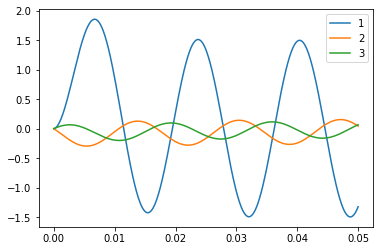

In [9]:
def plotNode(phase):
    waveforms = [
        results.get_voltage_drop(f'n1_a', f'n2_a'),
        results.get_voltage_drop(f'n1_b', f'n2_b'),
        results.get_voltage_drop(f'n1_c', f'n2_c')
    ]

    x = results.get_timesteps()

    plt.clf()

    count = 1
    for waveform in waveforms:
        plt.plot(x, waveform, label=str(count))
        count += 1

    plt.legend()
    plt.show()

plotNode('a')